Assumed dependencies: m0 * h, (h-d)/radwidth, h/(h-d2), (h-d1)/(h-d2), radwidth/(total radwidth).

Two steps:
1. Fix these, generate a lot of data, see how the histograms look (seek hints at other dependencies).
2. Fix three and vary 1 (m0h, h-d/radwidth), or fix two and vary two (the two height ratios) to see what happens and what dependencies might be.

Results:
1. Shockingly, all of the histograms except for a single damping one for 0.005 error have 1 bin (all the configurations converged at the same value). This strongly implies that all dependencies have been captured, except for possibly ones that come from "badly" shaped adjacent (middle) regions that need the outermost region to have a higher resolution to accommodate (all configurations here were run with small-ish (h-d)/radwidth for the other regions, promoting fast convergence). This can be explored later.

In [ ]:
import sys
import os
sys.path.append(os.path.relpath('../../../'))
sys.path.append(os.path.relpath('../../'))

from helpers import *
import numpy as np
from numpy import random

import matplotlib.pyplot as plt

In [7]:
def populate_hist_vals(m0h, hmdr, left_ratio, right_ratio, rad_ratio):
  hmd2 = random.uniform(low = 1., high = 50.)
  hmd1 = left_ratio * hmd2
  h = right_ratio * hmd2
  m0 = m0h/h
  radwidth2 = hmd2/hmdr
  rad0_rad1 = radwidth2 * (1/rad_ratio - 1)

  radwidth0, radwidth1, hmd0 = 0, 0, 0
  while radwidth0 <= 0 or hmd0 >= h:
    radwidth1 = hmd1/random.uniform(low = max(hmd1/rad0_rad1, 1), high = 3.)
    radwidth0 = rad0_rad1 - radwidth1
    hmd0 = random.uniform(low = max(1, h/radwidth0), high = 3.) * radwidth0

  hmds = [hmd0, hmd1, hmd2]
  radwidths = [radwidth0, radwidth1, radwidth2]
  d = [h - hmds[i] for i in range(3)]
  a = [sum(radwidths[:i + 1]) for i in range(3)]
  for i in range(3):
    assert radwidths[i] > 0
    assert d[i] > 0
  return h, d, a, m0

def swap_vals(prob, d, a):
  # Avoids mk recomputations.
  prob.d = d
  prob.a = a
  prob.scale = a
  return prob

In [ ]:
file1 = "histogram_data_2.pkl"

triples = [(2, 1.2, 0.5),
           (2, 0.99, 0.3),
           (10, 0.9, 0.2),
           (20, 0.7, 0.15),
           (20, 0.99, 0.1)]

hist_m0hs = [10, 40]
hist_rratios = [1.4, 3]

quints = [(m0h, triple[0], triple[1], rratio, triple[2]) for m0h in hist_m0hs
          for rratio in hist_rratios for triple in triples]

big_nmk = 200
nmk_max = 150
NMK = [big_nmk] * 4
heaving = [0, 0, 1]
rho = 1023

# fixed_prob_lsts = []

# for quint in quints:
#   fixed_prob_lst = []
#   print(quint)
#   for j in range(50):
#     h, d, a, m0 =  populate_hist_vals(quint[0], quint[1], quint[2], quint[3], quint[4])
#     prob = ConvergenceProblemI(h, d, a, heaving, NMK, m0, rho)
#     mk = prob.m_k
#     info = {"h" : h,
#             "d" : d,
#             "a" : a,
#             "region" : 2,
#             "m0s" : [m0]}
#     print(j, info)
#     data_dict = merge_dicts(info, prob.convergence_study_over_m0s(nmk_max, [m0], [mk]))
#     fixed_prob_lst.append(data_dict)
#   fixed_prob_lsts.append(fixed_prob_lst)
#   update_data_file(fixed_prob_lsts, file1)
#   print("Finished a quint.")

(10, 2, 1.2, 1.4, 0.5)
0 {'h': 7.658933877587035, 'd': [0.36211831465048405, 1.0941334110838614, 2.1882668221677237], 'a': [0.10188061972373541, 2.7353335277096558, 5.4706670554193115], 'region': 2, 'm0s': [1.3056647517566142]}
1 {'h': 27.671862695167306, 'd': [6.270082964918032, 3.9531232421667575, 7.906246484333515], 'a': [0.7073150124309198, 9.882808105416895, 19.76561621083379], 'region': 2, 'm0s': [0.36137791337575653]}
2 {'h': 13.361139511734848, 'd': [2.1157647804549704, 1.908734215962122, 3.817468431924242], 'a': [0.7708745170408307, 4.771835539905303, 9.543671079810606], 'region': 2, 'm0s': [0.7484391575446975]}
3 {'h': 48.12952503306149, 'd': [33.54507303515193, 6.875646433294499, 13.751292866588997], 'a': [0.8205144915834452, 17.189116083236247, 34.37823216647249], 'region': 2, 'm0s': [0.20777267162164442]}
4 {'h': 3.0633107005537306, 'd': [2.727800785241893, 0.43761581436481833, 0.8752316287296371], 'a': [0.061917840899549326, 1.0940395359120467, 2.1880790718240934], 'regio

In [18]:
fixed_prob_lsts = open_pkl_file(file1)
for fixed_prob_lst in fixed_prob_lsts:
  generate_convergence_data(fixed_prob_lst, [0.01, 0.005])
  # Ignoring log data for now.
  # log_data = generate_log_data(fixed_prob_lst)

In [10]:
def histogram(data, hydro, error, ylab = "count", title = "convergence"):
  vals = [data_dict[data_dict["m0s"][0]][f"convergence point {error:.2g} " + hydro] for data_dict in data]
  if min(vals) == max(vals):
    bins = [vals[0] - 0.5, vals[0] + 0.5]
  else:
    bins = np.arange(min(vals)-0.5, max(vals)+1.5, 1)
  plt.hist(vals, bins = bins, edgecolor = "black")
  plt.xlabel(f"convergence point {error:.2g} " + hydro)
  plt.ylabel(ylab)
  plt.title(hydro + " " + title)
  plt.show()
  return vals

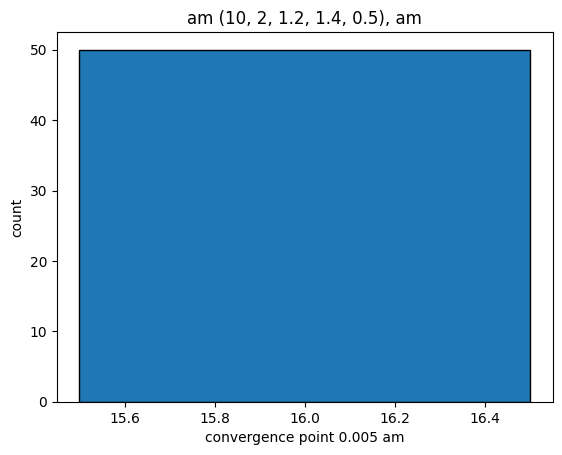

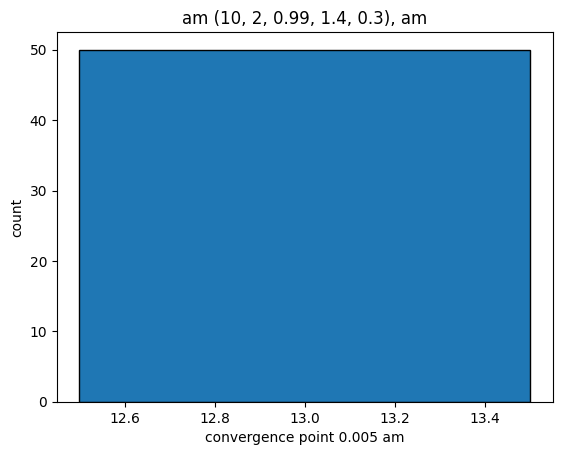

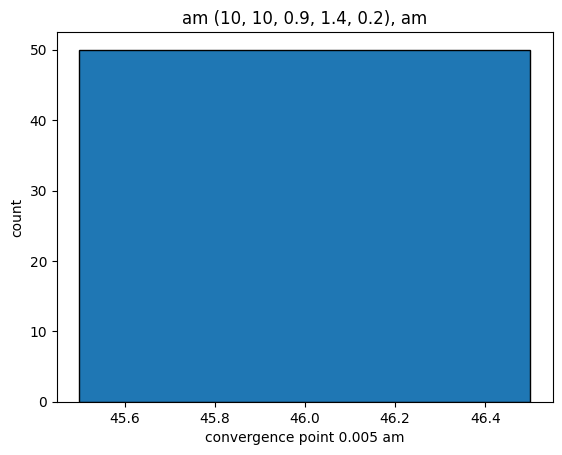

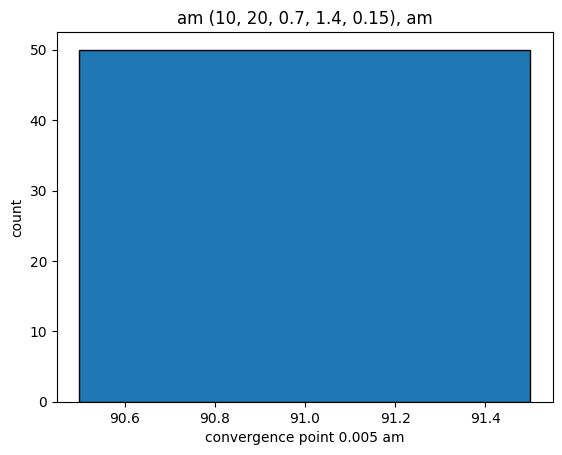

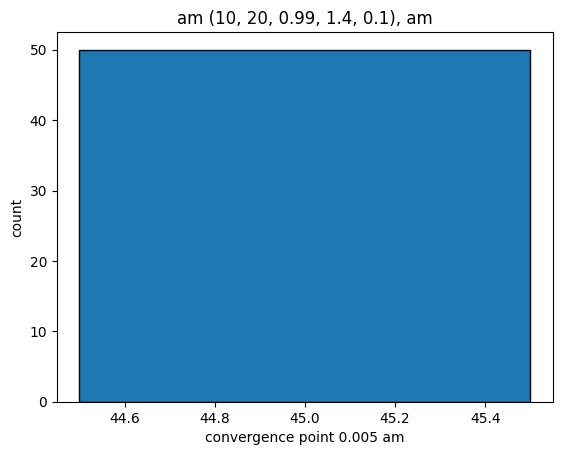

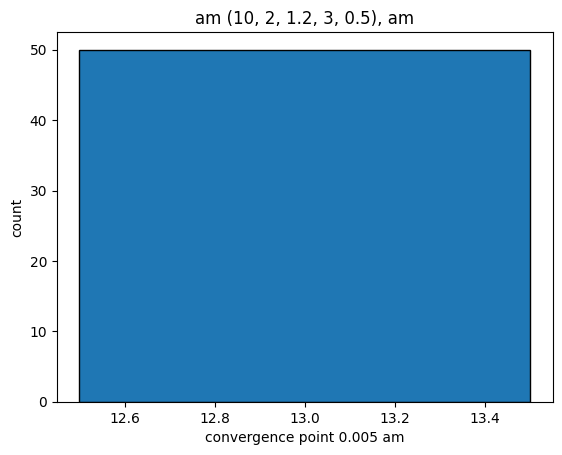

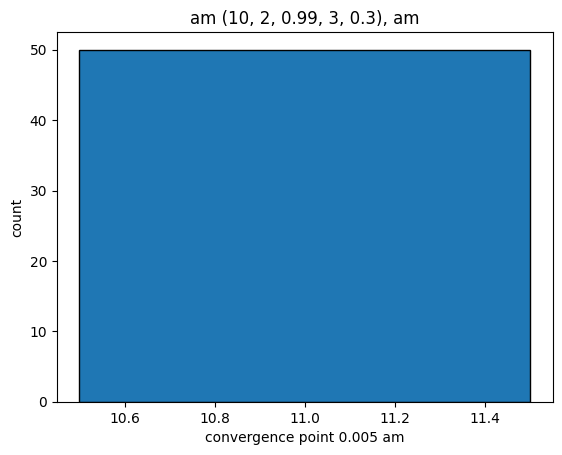

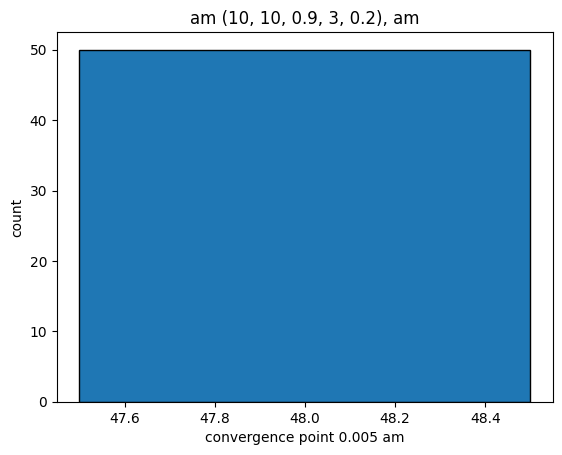

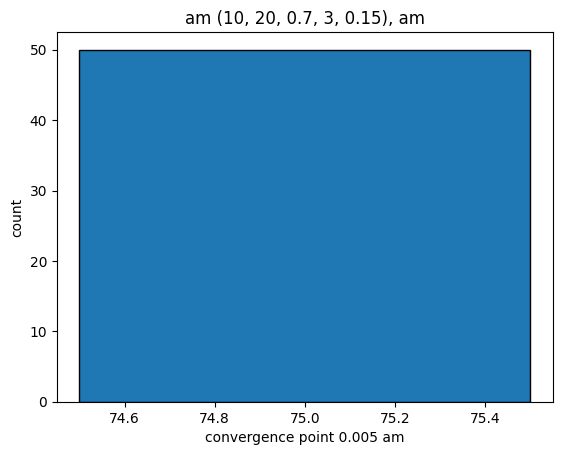

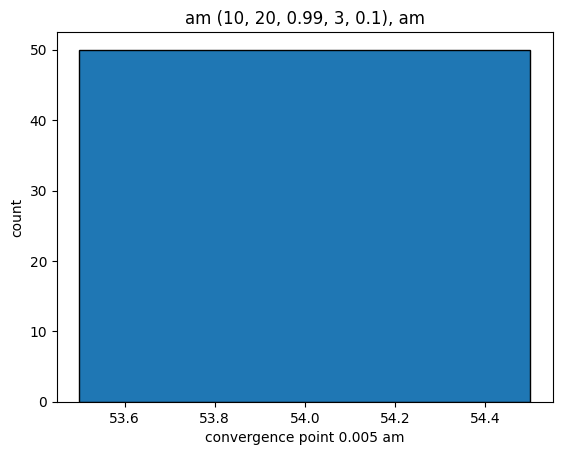

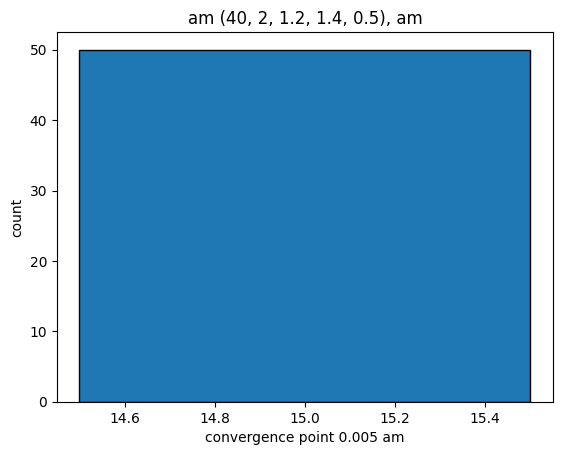

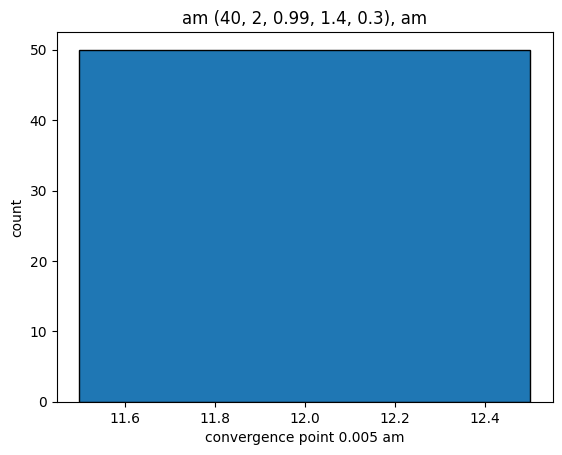

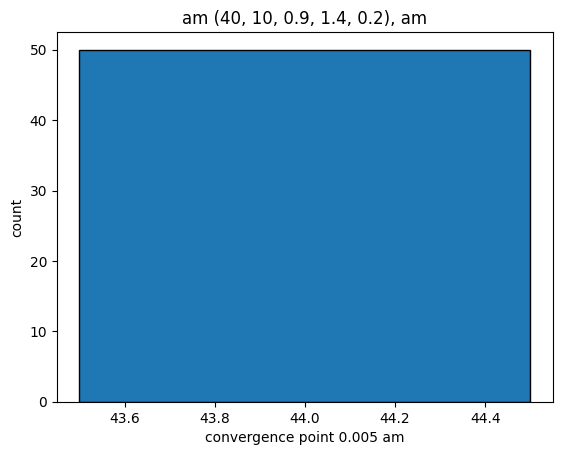

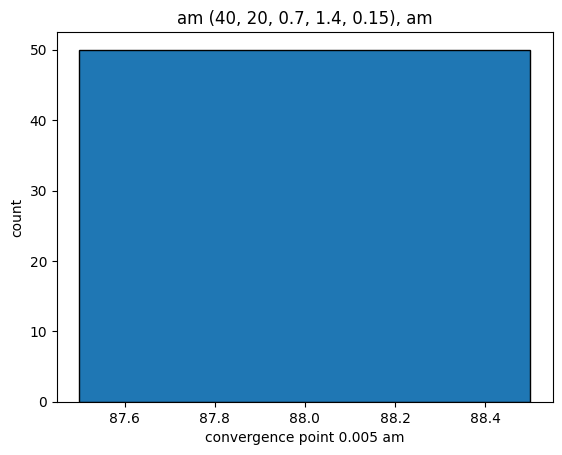

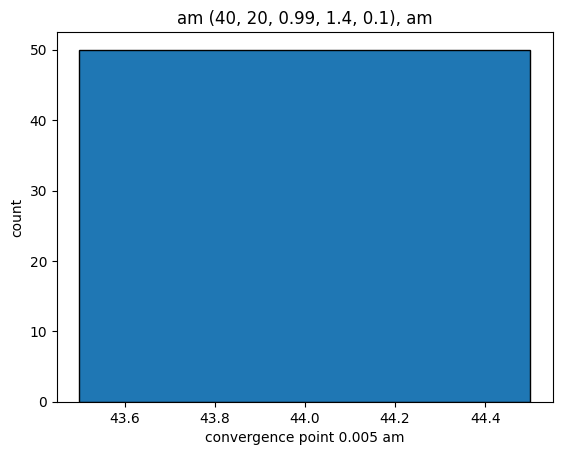

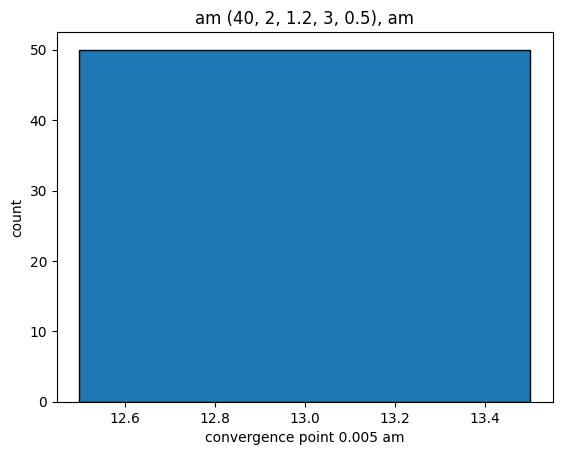

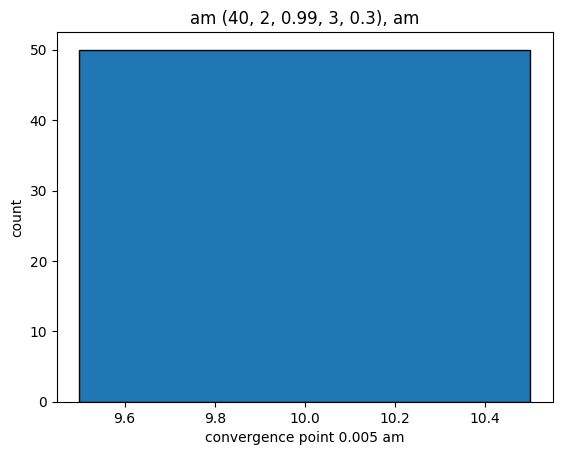

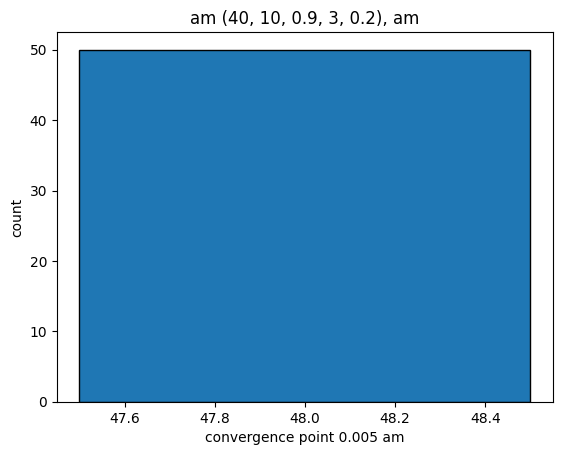

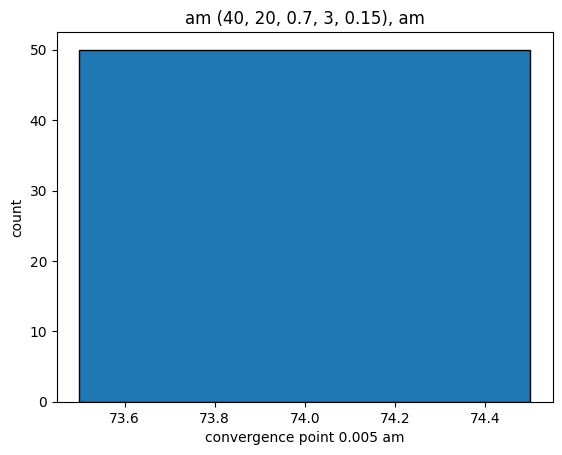

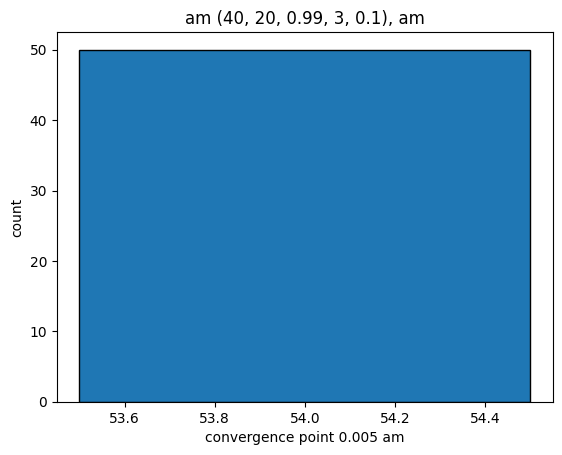

In [23]:
wide_variation_cases = []
for idx, quint in enumerate(quints):
  vals = histogram(fixed_prob_lsts[idx],"am", 0.005, ylab = "count", title = f"{quint}, am")
  if max(vals) - min(vals) > 7:
    wide_variation_cases.append(idx)

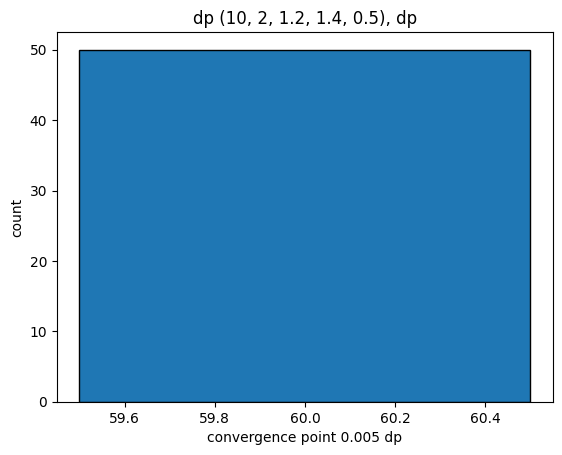

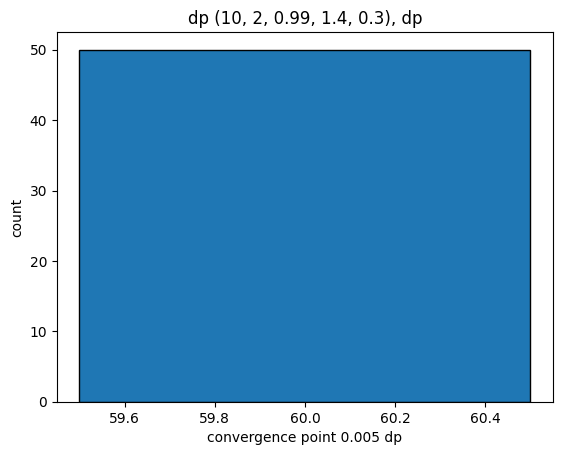

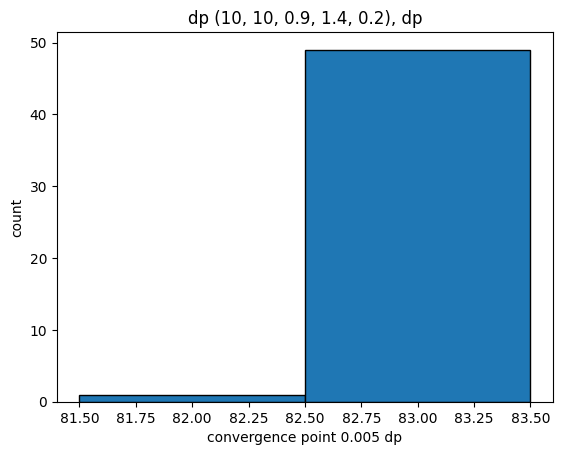

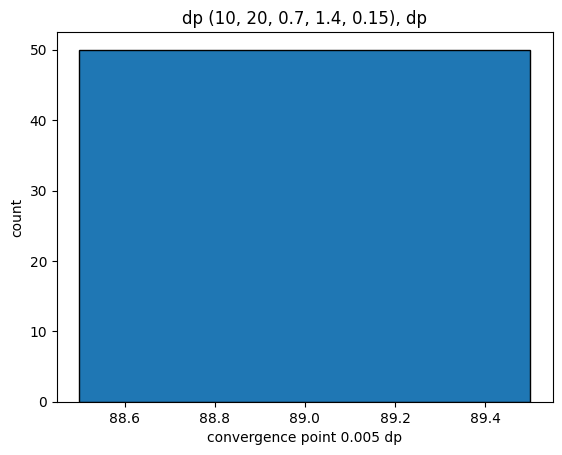

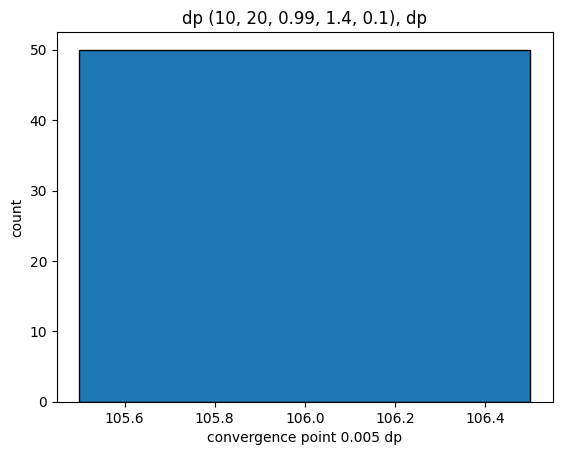

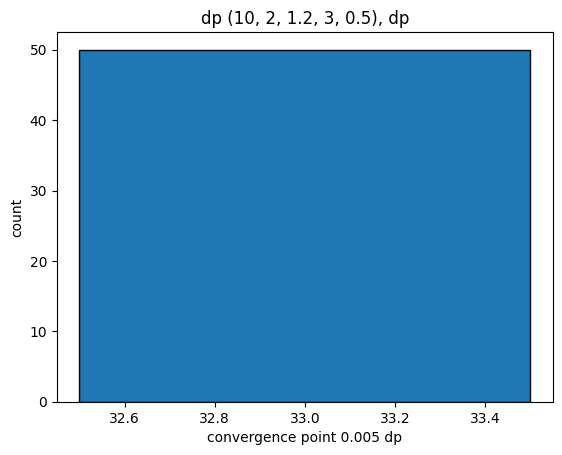

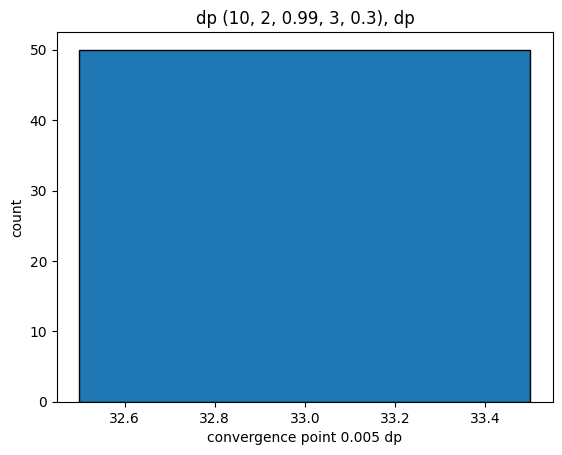

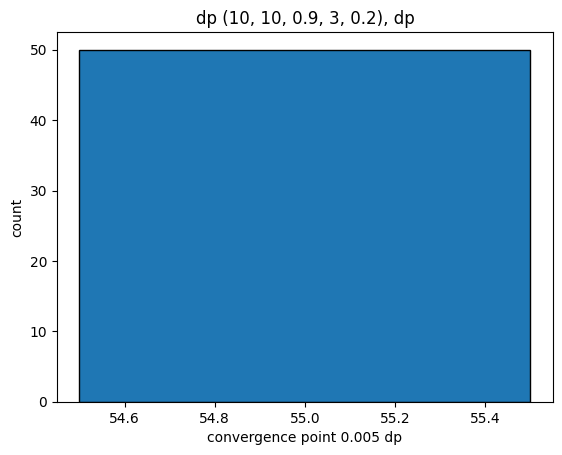

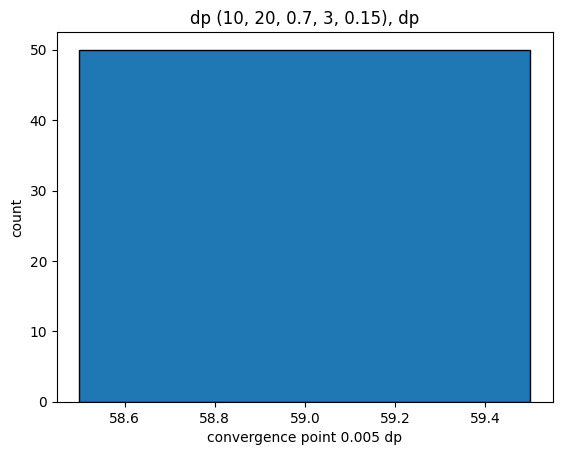

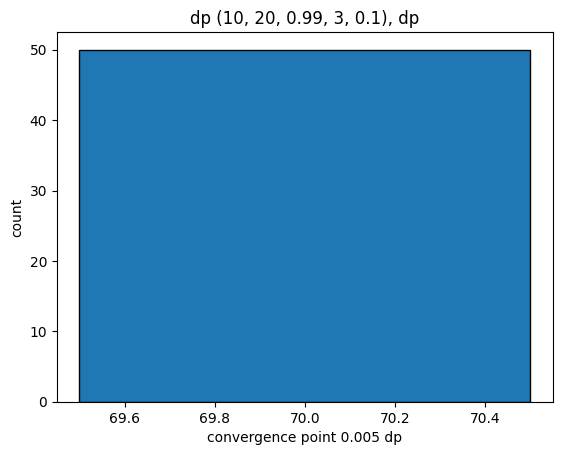

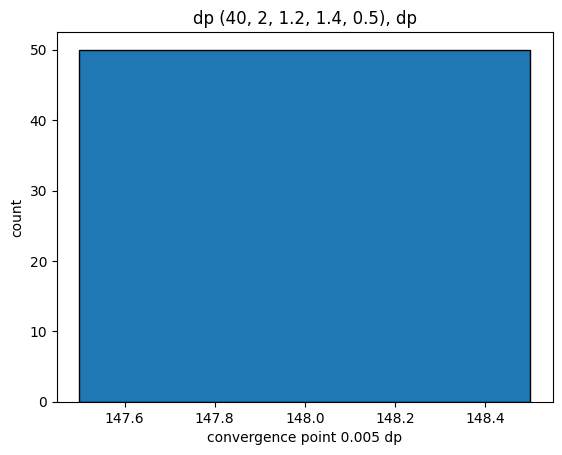

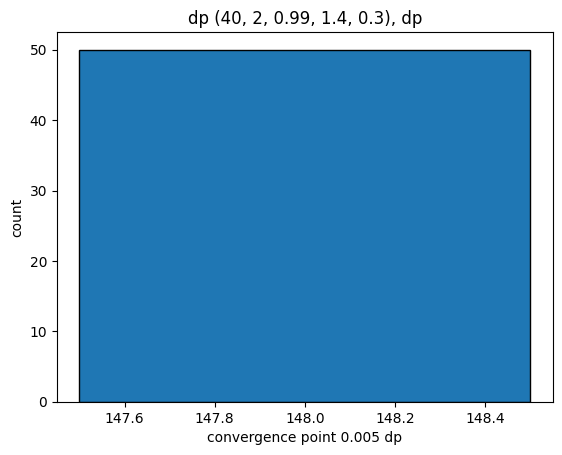

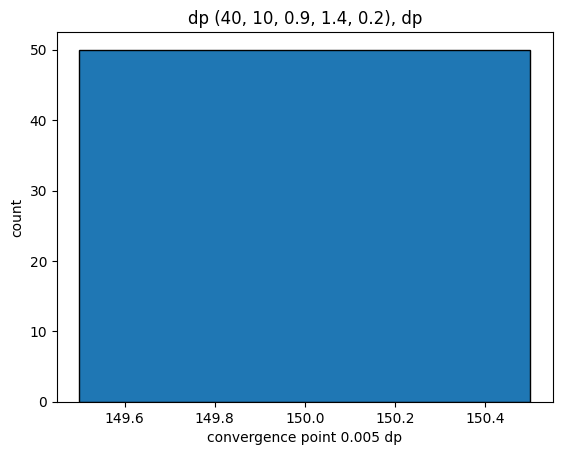

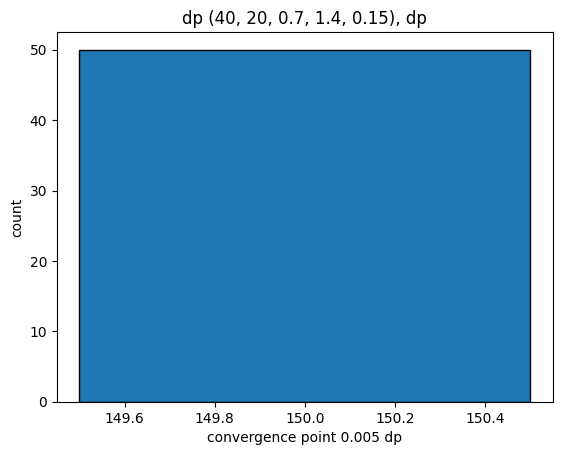

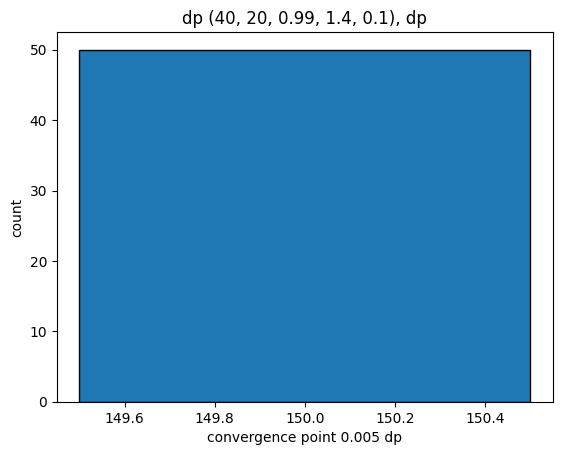

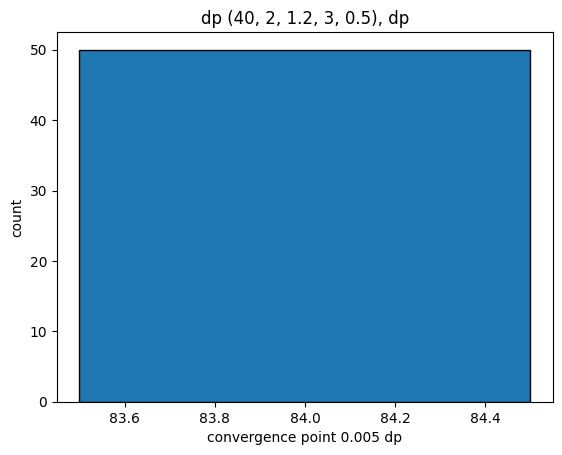

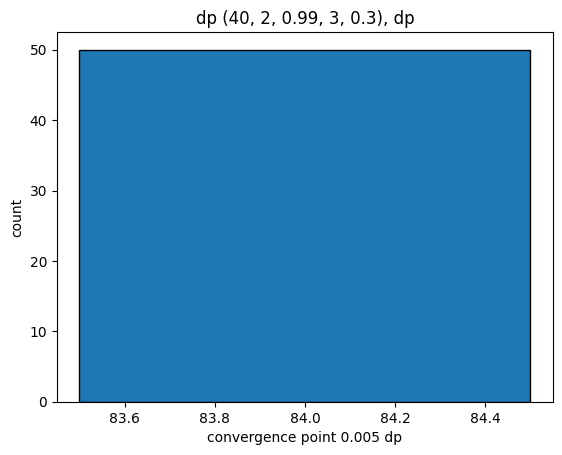

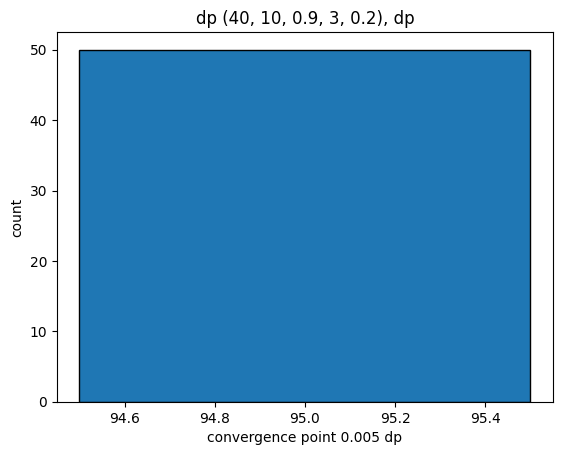

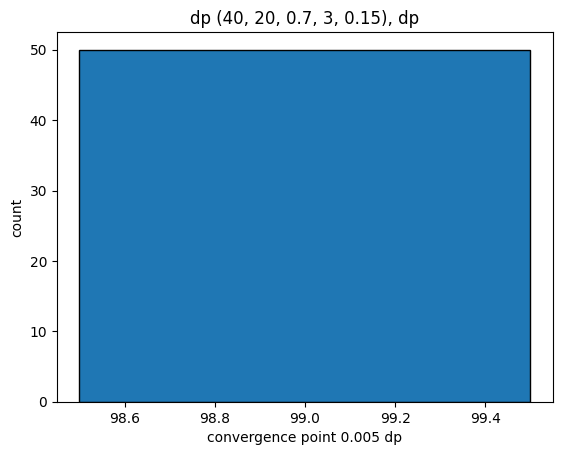

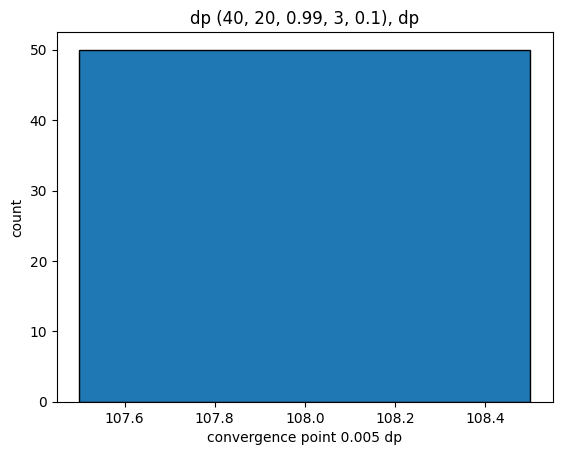

In [24]:
# wide_variation_cases = []
for idx, quint in enumerate(quints):
  vals = histogram(fixed_prob_lsts[idx],"dp", 0.005, ylab = "count", title = f"{quint}, dp")
  # if max(vals) - min(vals) > 10:
  #   wide_variation_cases.append(idx)

In [38]:
def plot_varied_cases(fixed_prob_lsts, idx, hydro):
  subset = fixed_prob_lsts[idx].copy()
  val_func = lambda data: data[data["m0s"][0]]["convergence point 0.01 " + hydro]
  subset.sort(key = val_func)
  vals = [val_func(data) for data in subset]
  min_val = min(vals)
  max_val = max(vals)
  if min_val == max_val:
    min_val, max_val = 1, 150
  filter_and_plot_shapes(subset, lambda data_dict, m0 : True, 
                        lambda data_dict, m0 : get_plasma_color(data_dict[m0]["convergence point 0.01 " + hydro], min_value = min_val, max_value=max_val),
                        ppr = 10, figsize_per_plot = (2, 2))
  # xs = [(data_dict["a"][2] - data_dict["a"][1])/data_dict["a"][2] for data_dict in subset]
  # ys = [data_dict[data_dict["m0s"][0]]["convergence point 0.01 am"] for data_dict in subset]
  # plt.plot(xs, ys)
  # plt.xlabel("radwidth2/(total body radius)")
  # plt.ylabel("convergence point")
  # plt.show()

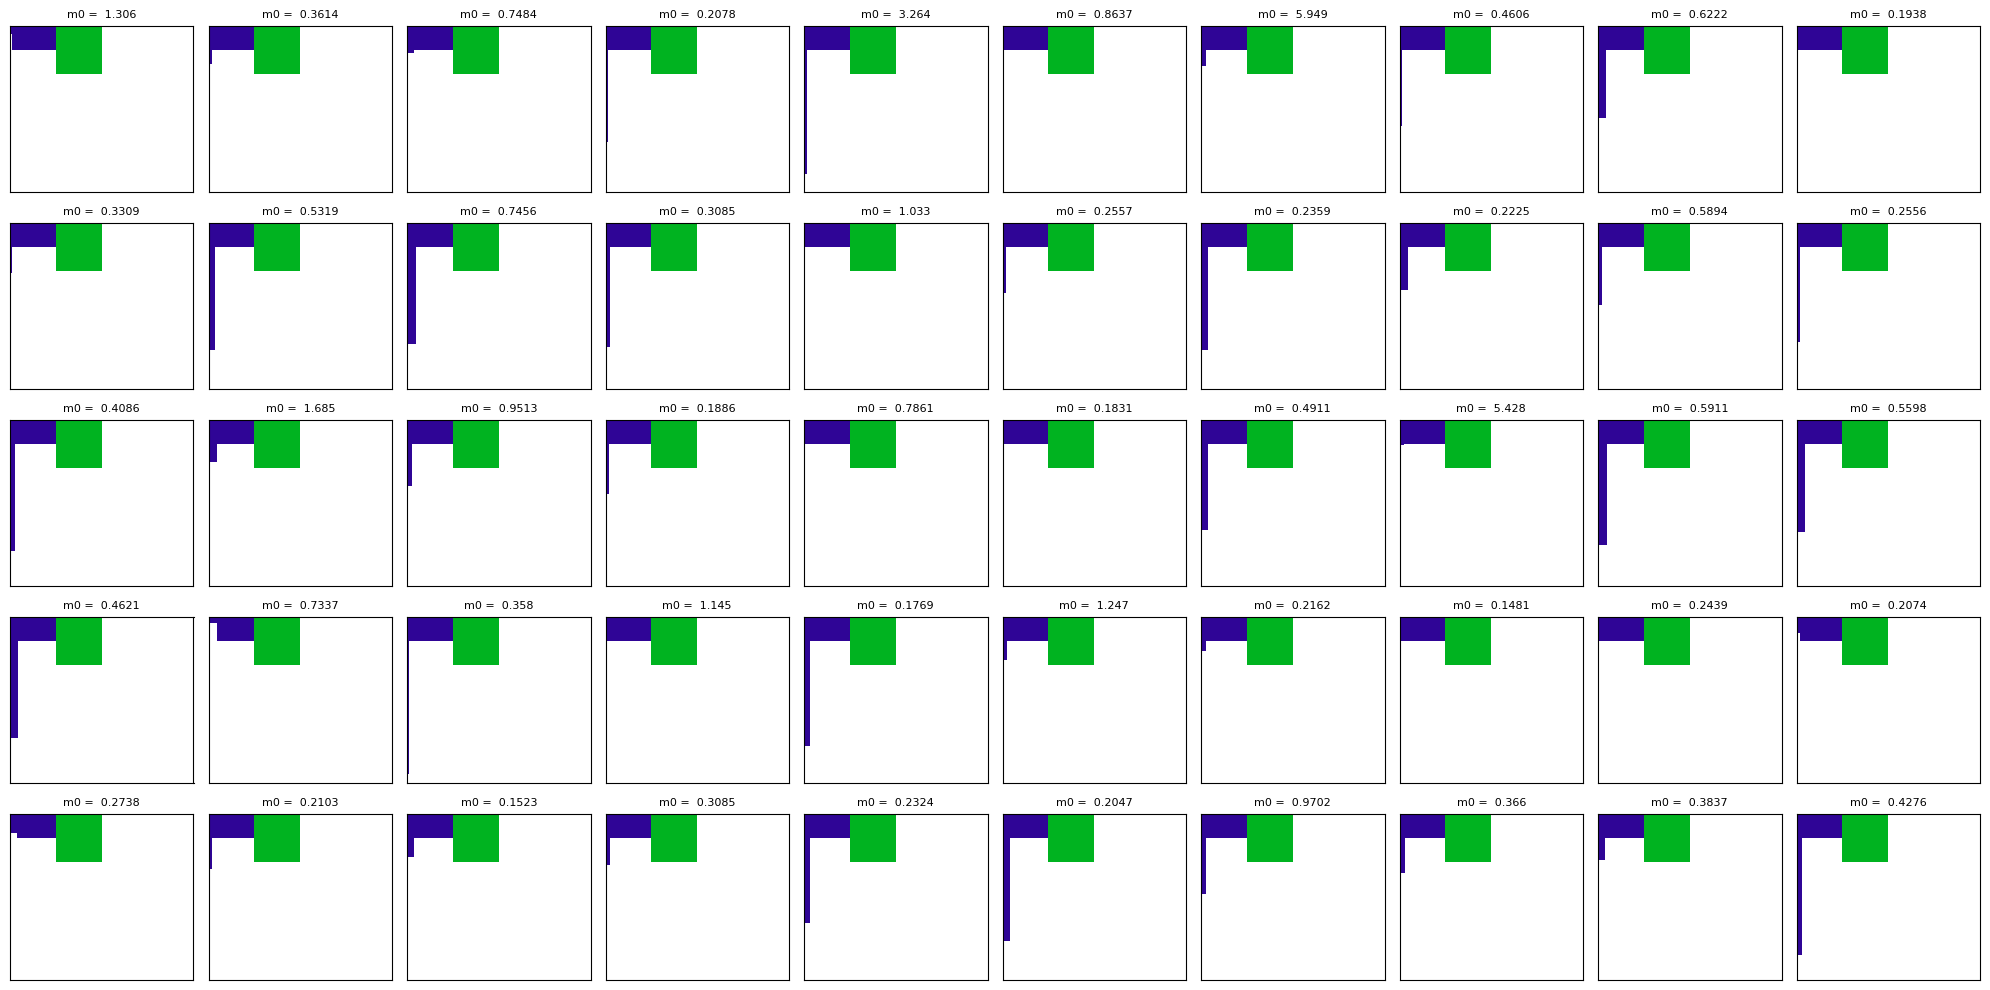

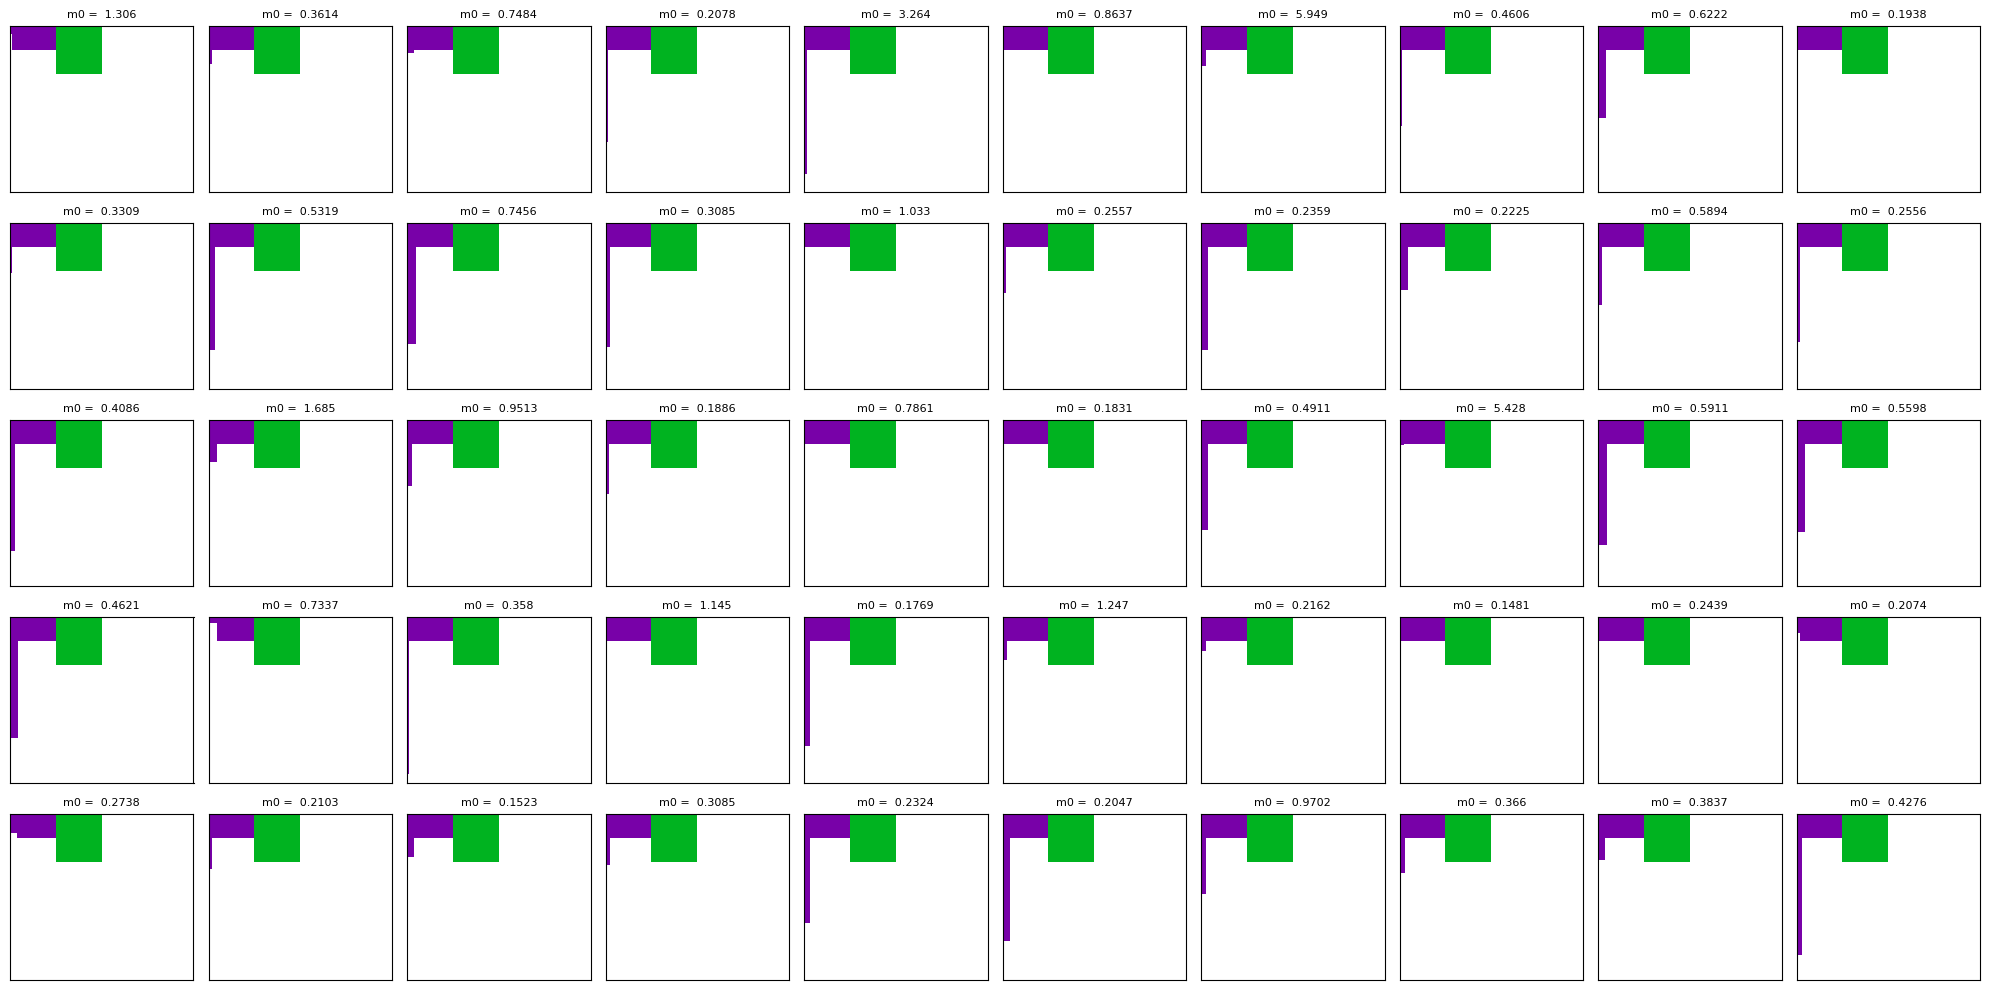

In [39]:
# visually confirm that the configurations generated are indeed different in some respects
plot_varied_cases(fixed_prob_lsts, 0, "am")
plot_varied_cases(fixed_prob_lsts, 0, "dp")

In [73]:
def populate_predet_d_a(h, m0h, hmdr, left_ratio, right_ratio, rad_ratio):
  m0 = m0h/h
  hmd2 = h/right_ratio
  hmd1 = left_ratio * hmd2
  radwidth2 = hmd2/hmdr
  rad0_rad1 = radwidth2 * (1/rad_ratio - 1)

  radwidth1 = hmd1 # arbitrary divide by 1
  radwidth0 = rad0_rad1 - radwidth1
  hmd0 = radwidth0 # arbitrary multiply by 1


  hmds = [hmd0, hmd1, hmd2]
  radwidths = [radwidth0, radwidth1, radwidth2]
  d = [h - hmds[i] for i in range(3)]
  a = [sum(radwidths[:i + 1]) for i in range(3)]
  for i in range(3):
     assert radwidths[i] > 0
     assert d[i] > 0
  
  return m0, d, a

def solve_and_store(h, m0, mk, prob, nmk_max, d, a, region = 2):
  info = {"h" : h,
          "d" : d,
          "a" : a,
          "region" : region,
          "m0s" : [m0]}
  print(info)
  swap_vals(prob, d, a)
  return merge_dicts(info, prob.convergence_study_over_m0s(nmk_max, [m0], [mk]))

def solve_and_store_m0(h, m0, heaving, NMK, nmk_max, d, a, region = 2):
    info = {"h" : h,
          "d" : d,
          "a" : a,
          "region" : region,
          "m0s" : [m0]}
    print(info)
    prob = ConvergenceProblemI(h, d, a, heaving, NMK, m0, rho)
    mk = prob.m_k
    return merge_dicts(info, prob.convergence_study_over_m0s(nmk_max, [m0], [mk]))

In [131]:
# Helper functions to find a good input range.
def precheck(hmdr, left_ratio, right_ratio, rad_ratio):
  condition1 = ((1/rad_ratio - 1) < (hmdr * (left_ratio + right_ratio)))
  condition2 = ((left_ratio * hmdr) < (1/rad_ratio - 1))
  return condition1 and condition2

def find_true_ranges(f, v_min, v_max, step):
  ranges = []
  lower, upper = 0, 0
  incumbent = False
  val = v_min
  while val <= v_max:
    truth_val = f(val)
    if not incumbent and not truth_val:
      pass
    elif not incumbent and truth_val:
      incumbent = True
      lower = val
      upper = val
    elif incumbent and truth_val:
      upper = val
    else:
      ranges.append((lower, upper))
      incumbent = False
    val += step
  if incumbent:
    ranges.append((lower, upper))
  return ranges

hmdrs = [15]
left_ratios = [0.2, 0.6, 0.8, 0.99, 1.2]
right_ratios = [1.1, 1.3, 2, 6]
rad_ratios = [0.2]

# for rad_ratio in rad_ratios:
#   for hmdr in hmdrs:
#     for left_ratio in left_ratios:
#       tups = find_true_ranges(lambda x : precheck(hmdr, left_ratio, x, rad_ratio), 1.05, 6, 0.05)
#       print(f"radr = {rad_ratio}, lr = {left_ratio}, hmdrs = {hmdr}, rr = {tups}")

# right_ratios = list(np.linspace(1.05, 1.5, 10)) + list(np.linspace(1.6, 2, 5)) + list(np.linspace(2.25, 6, 16))
quads = [(15, 0.99, 1.3, 0.05), (15, 1.2, 1.3, 0.05), (15, 0.99, 6, 0.05),
         (20, 0.2, 2, 0.1), (20, 0.8, 2, 0.05), (15, 0.2, 2, 0.2)]

for quad in quads:
  print(quad)
  populate_predet_d_a(30, 30, quad[0], quad[1], quad[2], quad[3])

# (15, 0.99, 1.3, 0.05), (15, 1.2, 1.3, 0.05), (15, 0.99, 6, 0.05), (20, 0.2, 2, 0.1), (20, 0.8, 2, 0.05), (15, 0.2, 2, 0.2)


(15, 0.99, 1.3, 0.05)
(15, 1.2, 1.3, 0.05)
(15, 0.99, 6, 0.05)
(20, 0.2, 2, 0.1)
(20, 0.8, 2, 0.05)
(15, 0.2, 2, 0.2)


In [132]:
file2 = "predetermined_1.pkl"

# all_data = {key : [] for key in ["m0h", "(h-d)/radwidth", "left ratio", "right ratio", "rad ratio"]}
all_data = open_pkl_file(file2)

big_nmk = 200
nmk_max = 150
NMK = [big_nmk] * 4
heaving = [0, 0, 1]
rho = 1023

h = 30
m0h = 30

# prob = ConvergenceProblemI(h, [1,1,1], [1,2,3], heaving, NMK, m0h/h, rho)
# mk = prob.m_k

# right ratios
# right_ratios = list(np.linspace(1.05, 1.5, 10)) + list(np.linspace(1.6, 2, 5)) + list(np.linspace(2.25, 6, 16))
# quads = ([(20, 0.2, rr, 0.1) for rr in right_ratios] +
#          [(20, 0.8, rr, 0.05) for rr in right_ratios] +
#          [(10, 0.99, rr, 0.05) for rr in right_ratios] +
#          [(10, 1.2, rr, 0.05) for rr in right_ratios[4:]])
# for idx, quad in enumerate(quads):
#   m0, d, a = populate_predet_d_a(h, m0h, quad[0], quad[1], quad[2], quad[3])
#   data_dict = solve_and_store(h, m0, mk, prob, nmk_max, d, a)
#   all_data["right ratio"].append(data_dict)
#   if idx % 10 == 0:
#     update_data_file(all_data, file2)
# update_data_file(all_data, file2)

# left ratios
# right_ratios = [1.3, 2, 6]
# quads = ([(10, lr, rr, 0.1) for rr in right_ratios for lr in list(np.linspace(0.1, 0.85, 16))] +
#          [(10, lr, rr, 0.05) for rr in right_ratios[1:] for lr in list(np.linspace(0.1, 1.85, 36))] +
#          [(10, lr, 1.3, 0.05) for lr in list(np.linspace(0.65, 1.25, 13))] +
#          [(10, lr, rr, 0.05) for rr in right_ratios for lr in list(np.linspace(0.91, 1.09, 19))])
# for idx, quad in enumerate(quads):
#   m0, d, a = populate_predet_d_a(h, m0h, quad[0], quad[1], quad[2], quad[3])
#   data_dict = solve_and_store(h, m0, mk, prob, nmk_max, d, a)
#   all_data["left ratio"].append(data_dict)
#   if idx % 10 == 0:
#     update_data_file(all_data, file2)
# update_data_file(all_data, file2)

# rad ratios
# right_ratios = [1.3, 2, 6]
# quads = ([(2, 0.2, rr, radr) for rr in right_ratios for radr in list(np.linspace(0.28, 0.7, 8))] + 
#          [(2, 0.99, rr, radr) for rr in right_ratios for radr in list(np.linspace(0.2, 0.32, 5))] + 
#          [(2, 1.2, rr, radr) for rr in right_ratios for radr in list(np.linspace(0.18, 0.28, 5))] + 
#          [(10, 0.2, rr, radr) for rr in right_ratios for radr in list(np.linspace(0.08, 0.33, 6))] + 
#          [(20, 0.2, rr, radr) for rr in right_ratios for radr in list(np.linspace(0.04, 0.19, 16))])
# for idx, quad in enumerate(quads):
#   m0, d, a = populate_predet_d_a(h, m0h, quad[0], quad[1], quad[2], quad[3])
#   data_dict = solve_and_store(h, m0, mk, prob, nmk_max, d, a)
#   all_data["rad ratio"].append(data_dict)
#   if idx % 10 == 0:
#     update_data_file(all_data, file2)
# update_data_file(all_data, file2)

# (h-d)/radwidths
# right_ratios = [1.3, 2, 6]
# left_ratios = [0.2, 0.99, 1.2]
# quads = ([(hmdr, left_ratio, 6, 0.01) for left_ratio in left_ratios for hmdr in list(np.linspace(16, 25, 10))] +
#          [(hmdr, 0.2, right_ratio, 0.05) for right_ratio in right_ratios for hmdr in list(np.linspace(13, 25, 13))] +
#          [(hmdr, 0.99, right_ratio, 0.05) for right_ratio in right_ratios for hmdr in list(np.linspace(9, 19, 11))] +
#          [(hmdr, 1.2, right_ratio, 0.05) for right_ratio in right_ratios for hmdr in list(np.linspace(8, 15, 15))] +
#          [(hmdr, 0.2, right_ratio, 0.1) for right_ratio in right_ratios for hmdr in list(np.linspace(7, 25, 19))] +
#          [(hmdr, 0.2, right_ratio, 0.2) for right_ratio in right_ratios for hmdr in list(np.linspace(3, 19, 17))])
# for idx, quad in enumerate(quads):
#   m0, d, a = populate_predet_d_a(h, m0h, quad[0], quad[1], quad[2], quad[3])
#   data_dict = solve_and_store(h, m0, mk, prob, nmk_max, d, a)
#   all_data["(h-d)/radwidth"].append(data_dict)
#   if idx % 10 == 0:
#     update_data_file(all_data, file2)
# update_data_file(all_data, file2)

# m0hs
quads = [(15, 0.99, 1.3, 0.05), (15, 1.2, 1.3, 0.05), (15, 0.99, 6, 0.05),
         (20, 0.2, 2, 0.1), (20, 0.8, 2, 0.05), (15, 0.2, 2, 0.2)]
h = 30
m0hs = list(np.linspace(5, 70, 13))
for m0h in m0hs:
  prob = ConvergenceProblemI(h, [1,1,1], [1,2,3], heaving, NMK, m0h/h, rho)
  mk = prob.m_k
  for idx, quad in enumerate(quads):
    m0, d, a = populate_predet_d_a(h, m0h, quad[0], quad[1], quad[2], quad[3])
    data_dict = solve_and_store(h, m0, mk, prob, nmk_max, d, a)
    all_data["m0h"].append(data_dict)
  update_data_file(all_data, file2)


{'h': 30, 'd': [23.615384615384613, 7.153846153846153, 6.923076923076923], 'a': [6.384615384615387, 29.230769230769234, 30.769230769230774], 'region': 2, 'm0s': [np.float64(0.16666666666666666)]}
{'h': 30, 'd': [28.461538461538456, 2.30769230769231, 6.923076923076923], 'a': [1.5384615384615437, 29.230769230769234, 30.769230769230774], 'region': 2, 'm0s': [np.float64(0.16666666666666666)]}
{'h': 30, 'd': [28.616666666666667, 25.05, 25.0], 'a': [1.3833333333333329, 6.333333333333333, 6.666666666666666], 'region': 2, 'm0s': [np.float64(0.16666666666666666)]}
{'h': 30, 'd': [26.25, 27.0, 15.0], 'a': [3.75, 6.75, 7.5], 'region': 2, 'm0s': [np.float64(0.16666666666666666)]}
{'h': 30, 'd': [27.75, 18.0, 15.0], 'a': [2.25, 14.25, 15.0], 'region': 2, 'm0s': [np.float64(0.16666666666666666)]}
{'h': 30, 'd': [29.0, 27.0, 15.0], 'a': [1.0, 4.0, 5.0], 'region': 2, 'm0s': [np.float64(0.16666666666666666)]}
{'h': 30, 'd': [23.615384615384613, 7.153846153846153, 6.923076923076923], 'a': [6.38461538461

In [133]:
# Extract data and add convergence metrics to the dictionaries
all_data = open_pkl_file(file2)
log_data = {}
for key in all_data.keys():
  generate_convergence_data(all_data[key], [0.01, 0.005])
  log_data[key] = generate_log_data(all_data[key])
all_prob_dicts = [data_dict for data_dict in all_data[key] for key in all_data.keys()]

m0h


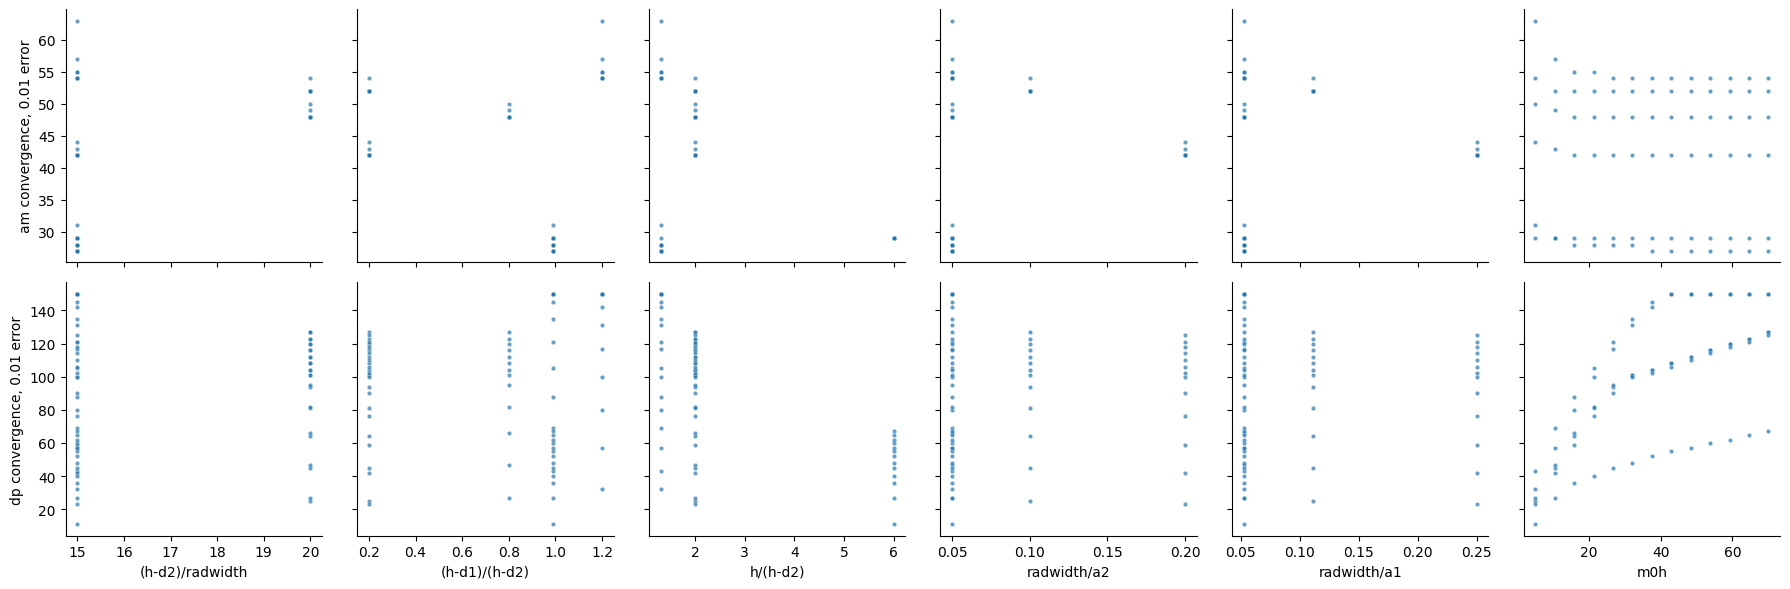

(h-d)/radwidth


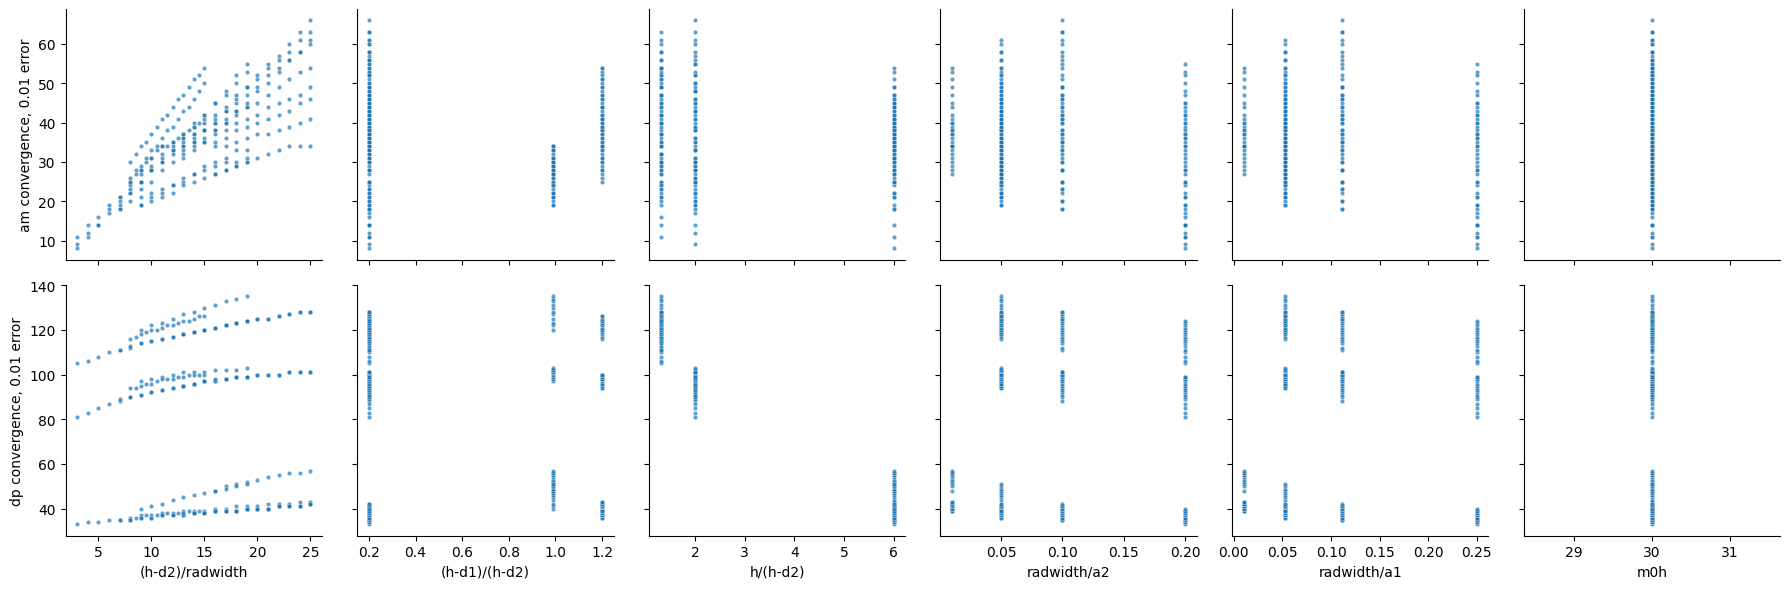

left ratio


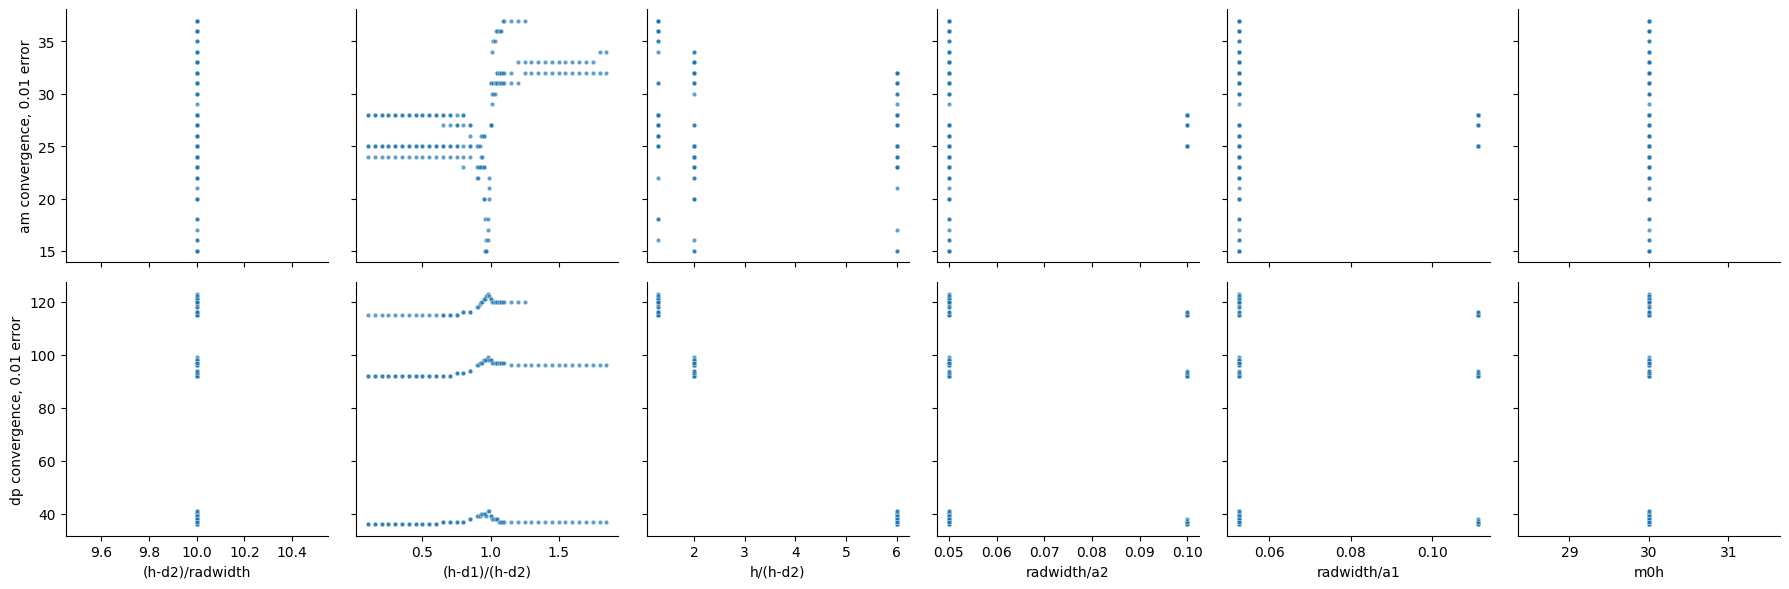

right ratio


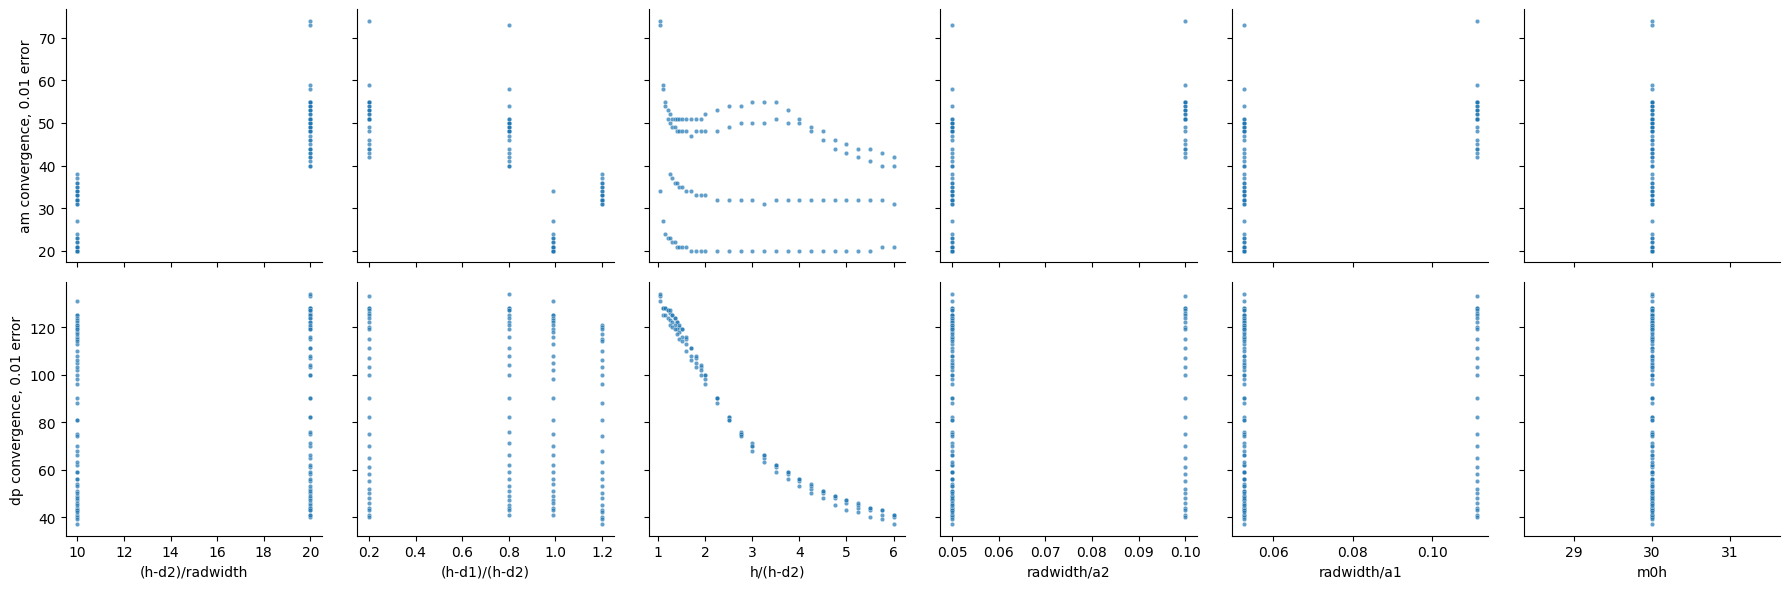

rad ratio


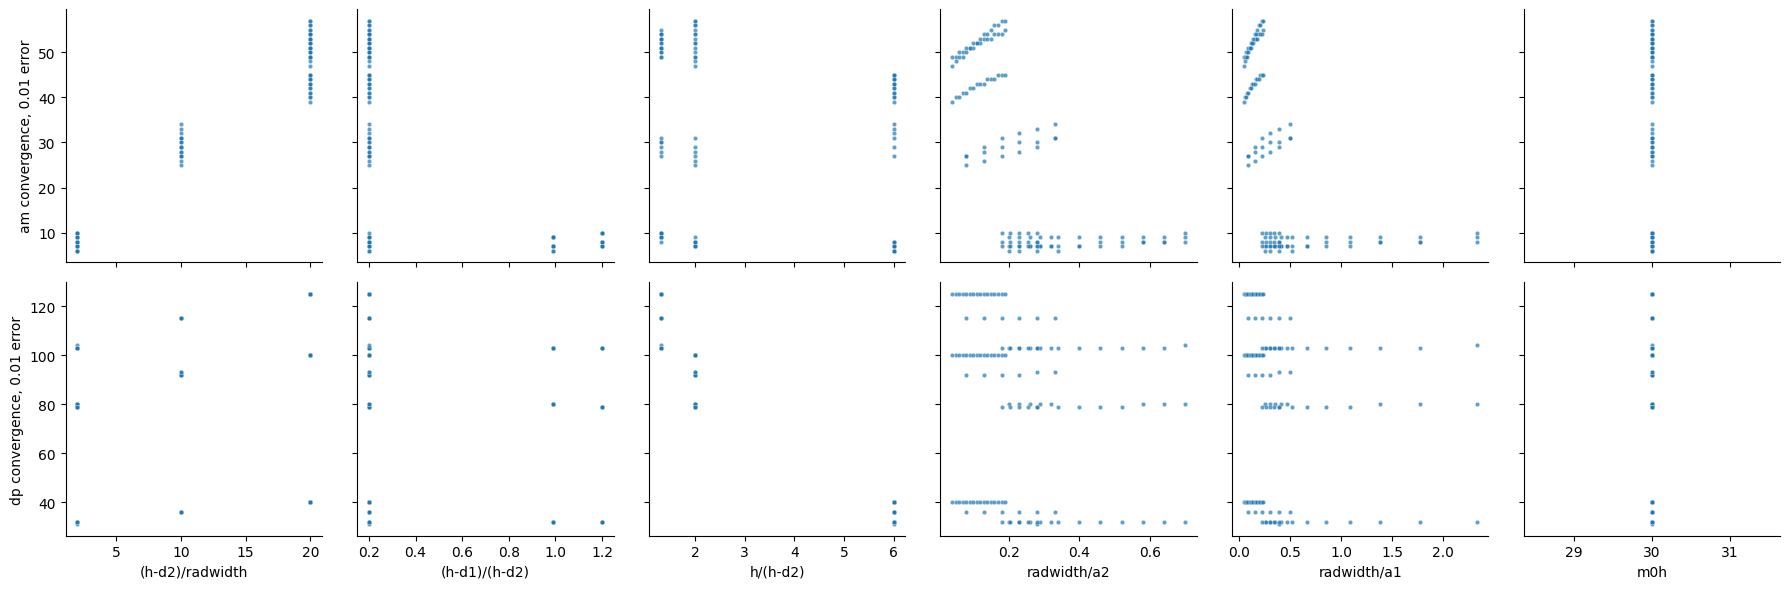

In [134]:
# Plot convergence point on y, various on x.
def xf1(config, m0):
  return (config["h"] - config["d"][2])/(config["a"][2] - config["a"][1])

def xf2(config, m0):
  return (config["h"] - config["d"][1])/(config["h"] - config["d"][2])

def xf3(config, m0):
  return (config["h"])/(config["h"] - config["d"][2])

def xf4(config, m0):
  return (config["a"][2] - config["a"][1])/(config["a"][2])

def xf5(config, m0):
  return (config["a"][2] - config["a"][1])/(config["a"][1])

def xf6(config, m0):
  return (config["h"] * m0)

def yf1(config, m0):
  return config[m0]["convergence point 0.01 am"]

def yf2(config, m0):
  return config[m0]["convergence point 0.005 am"]

def yf3(config, m0):
  return config[m0]["convergence point 0.01 dp"]

def yf4(config, m0):
  return config[m0]["convergence point 0.005 dp"]

x_funcs = {"(h-d2)/radwidth" : xf1,
           "(h-d1)/(h-d2)" : xf2,
           "h/(h-d2)" : xf3,
           "radwidth/a2" : xf4,
           "radwidth/a1" : xf5,
           "m0h" : xf6}
y_funcs = {"am convergence, 0.01 error" : yf1,
          #  "am convergence, 0.005 error" : yf2,
           "dp convergence, 0.01 error" : yf3,
          #  "dp convergence, 0.005 error" : yf4
           }

for key in all_data.keys():
  print(key)
  plot_relation_grid(all_data[key], x_funcs, y_funcs)

In [135]:
# variable metrics
def h_minus_d_over_radwidth(data_dict):
    region = data_dict["region"]
    radwidth = data_dict["a"][0] if region == 0 else (data_dict["a"][region] - data_dict["a"][region - 1])
    return (data_dict["h"] - data_dict["d"][region])/radwidth

def tall_theta(data_dict):
  hmdr = h_minus_d_over_radwidth(data_dict)
  return np.arctan(1/hmdr)

def right_ratio(data_dict):
  region = data_dict["region"]
  if region == (len(data_dict["d"]) - 1):
     return data_dict["h"]/(data_dict["h"] - data_dict["d"][region])
  else:
    return (data_dict["h"] - data_dict["d"][region + 1])/(data_dict["h"] - data_dict["d"][region])
    
def left_ratio(data_dict):
  region = data_dict["region"]
  if region == 0:
     return 0
  else:
    return (data_dict["h"] - data_dict["d"][region - 1])/(data_dict["h"] - data_dict["d"][region])
  
def rad_ratio(data_dict):
  region = data_dict["region"]
  radwidth = data_dict["a"][0] if region == 0 else (data_dict["a"][region] - data_dict["a"][region - 1])
  return radwidth/data_dict["a"][region]

def m0h(data_dict):
  return data_dict["h"] * data_dict["m0s"][0]

def restrict(all_data, f, val):
  return [data_dict for data_dict in all_data if (abs(f(data_dict) - val) < 0.001)]

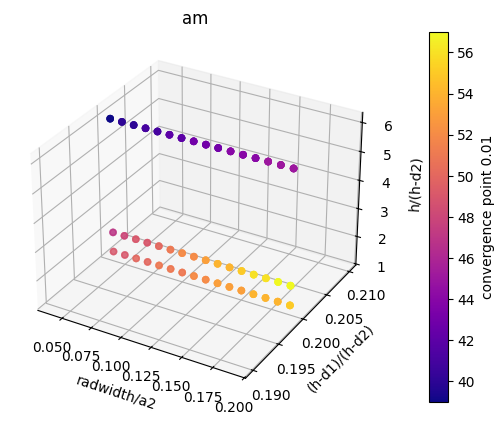

In [136]:
subset = restrict(all_prob_dicts, h_minus_d_over_radwidth, 20)
subset = restrict(subset, m0h, 30)

plot_hydros_against_3(subset, "am", 0.01,
                      wrap_m0(rad_ratio),
                      wrap_m0(left_ratio), wrap_m0(right_ratio),
                      "radwidth/a2", "(h-d1)/(h-d2)", "h/(h-d2)")

# subset = restrict(all_data['rad ratio'], right_ratio, 1.2)
# plot_hydros_against_3(subset, "am", 0.01,
#                       wrap_m0(rad_ratio),
#                       wrap_m0(left_ratio), wrap_m0(h_minus_d_over_radwidth),
#                       "radwidth/a1", "(h-d0)/(h-d1)", "(h-d)/radwidth")


In [137]:
# Plot a single variable against the convergence point
# Connect points with the same other variables with the same color

variable_funcs = {"(h-d1)/(h-d2)" : left_ratio,
                  "h/(h-d2)" : right_ratio,
                  "(h-d2)/radwidth" : h_minus_d_over_radwidth,
                  "radwidth/a2" : rad_ratio,
                  "m0h" : m0h}

def subdivide_lst(data_lst, f, rtol = 0.01):
  group_dict = {}
  for data_dict in data_lst:
    val = f(data_dict)
    stored = False
    for key in group_dict.keys():
      if abs((val - key)/key) < rtol:
        group_dict[key].append(data_dict)
        stored = True
        break
    if not stored:
      group_dict[val] = [data_dict]
  return [group_dict[key] for key in group_dict.keys()] # turn dict into lst of lsts

def plot_wrt_one(data, hydro, error, scale = False, xlab = "Invalid Key", func_pack = None, show_labs = False):
  xfunc = variable_funcs[xlab]
  other_funcs = variable_funcs.copy()
  del other_funcs[xlab]

  key1, key2, key3, key4 = other_funcs.keys()
  subdivision1 = subdivide_lst(data, other_funcs[key1])
  subdivision2 = [entry for sublist in subdivision1 for entry in subdivide_lst(sublist, other_funcs[key2])]
  subdivision3 = [entry for sublist in subdivision2 for entry in subdivide_lst(sublist, other_funcs[key3])]
  subdivision4 = [entry for sublist in subdivision3 for entry in subdivide_lst(sublist, other_funcs[key4])]
  # subdivision4 should be a list of lists of data_dicts, with uniform values across the three keys

  line_count = len(subdivision4)
  for lst in subdivision4:
    lst.sort(key = xfunc)
  
  if func_pack is not None: # Plotting a prediction on the x-axis instead
    entry_func = func_pack["function"]
    xlab = func_pack["xlab"]
  else:
    entry_func = xfunc

  colors = [cm.get_cmap('viridis')(i/(line_count - 1)) for i in range(line_count)]
  
  fig, ax = plt.subplots()
  for idx, data_lst in enumerate(subdivision4):
    xs = [entry_func(data_dict) for data_dict in data_lst]
    ys = [data_dict[data_dict["m0s"][0]][f"convergence point {error:.2g} " + hydro] for data_dict in data_lst]
    vs = [other_funcs[key](data_lst[0]) for key in other_funcs.keys()]
    lab = key1 + f"= {vs[0]:.2g}, " + key2 + f" = {vs[1]:.2g}, " + key3 + f" = {vs[2]:.2g}, " + key4 + f" = {vs[3]:.2g}, "
    if scale:
      ys = scale_by(ys, ys[0])
    plt.plot(xs, ys, color = colors[idx], label = lab)
  

  ax.set_xlabel(xlab)
  if scale:
    ylab = "Ratio of NMK at convergence to that for 1st config"
  else:
    ylab = "NMK at convergence"
  if show_labs:
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
  ax.set_ylabel(ylab)
  ax.set_title(hydro + " convergence wrt " + xlab)
  plt.show()

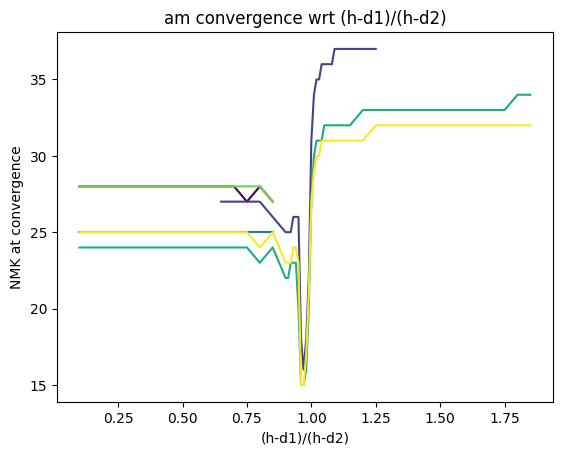

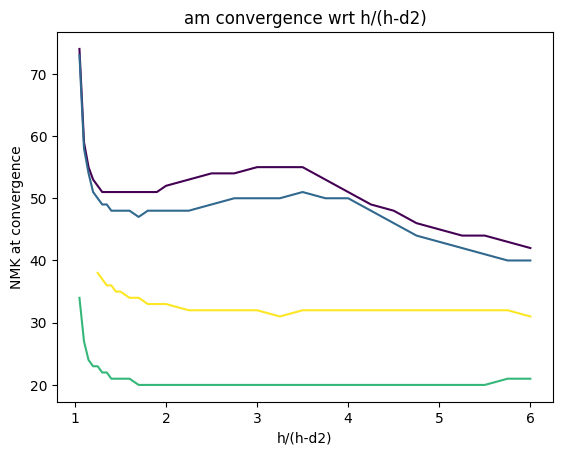

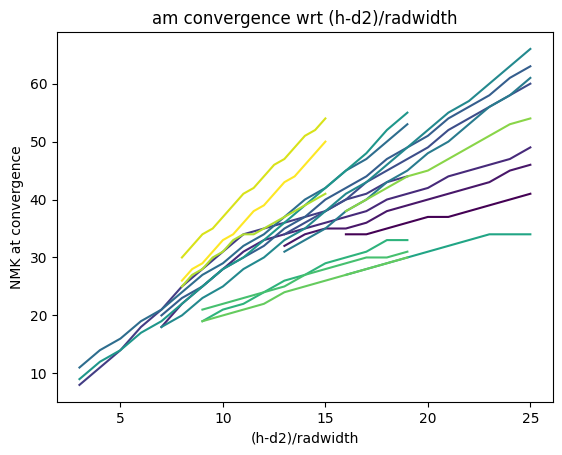

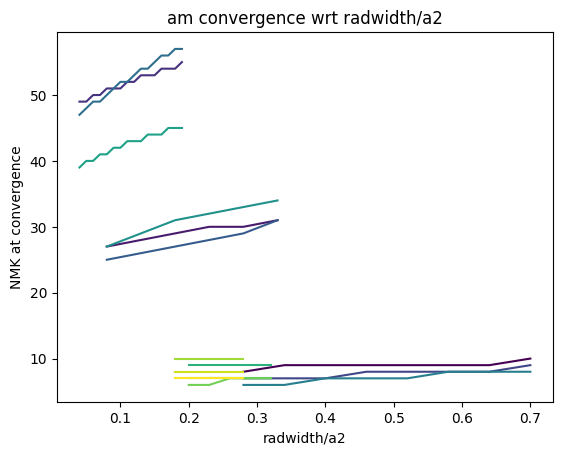

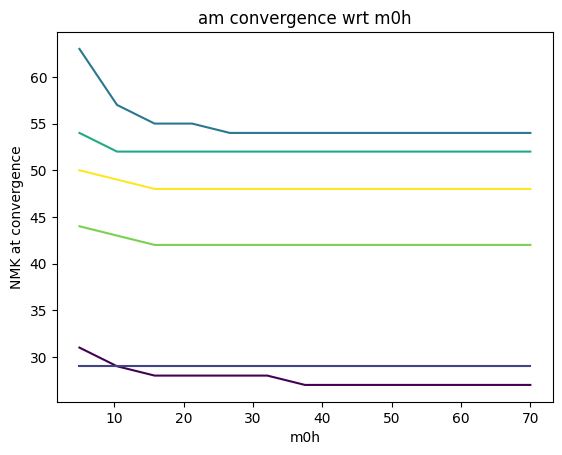

In [138]:
plot_wrt_one(all_data["left ratio"], "am", 0.01, xlab = "(h-d1)/(h-d2)")
plot_wrt_one(all_data["right ratio"], "am", 0.01, xlab = "h/(h-d2)")
plot_wrt_one(all_data["(h-d)/radwidth"], "am", 0.01, xlab = "(h-d2)/radwidth")
plot_wrt_one(all_data["rad ratio"], "am", 0.01, xlab = "radwidth/a2")
plot_wrt_one(all_data["m0h"], "am", 0.01, xlab = "m0h")

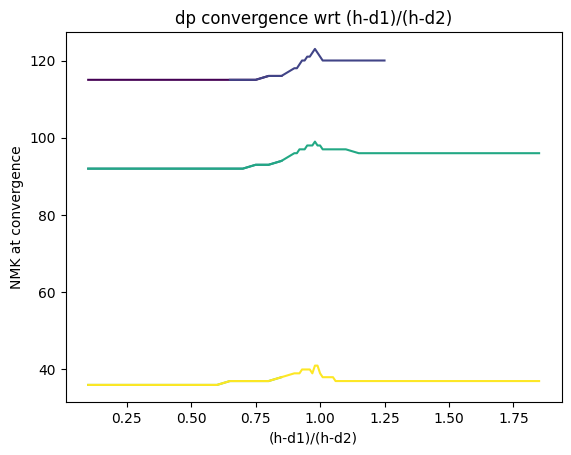

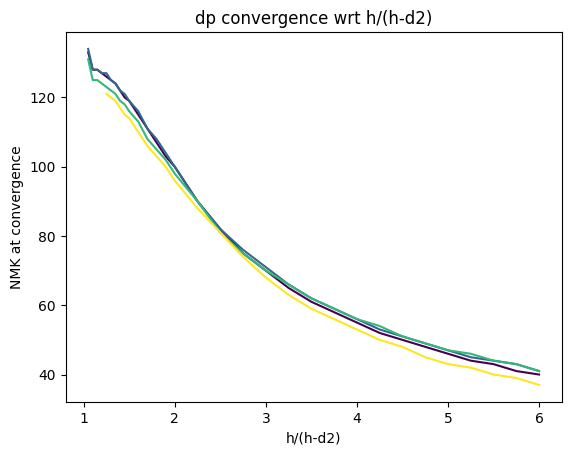

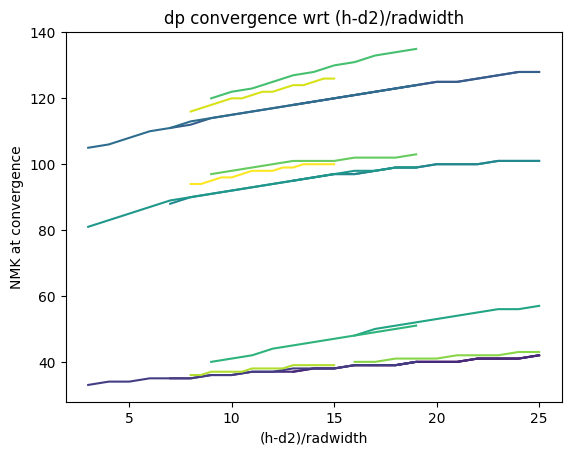

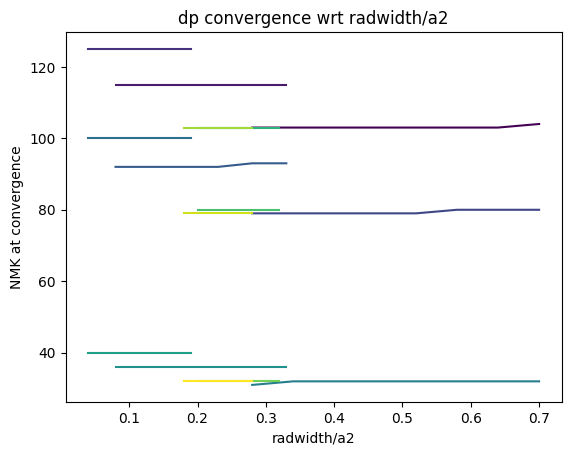

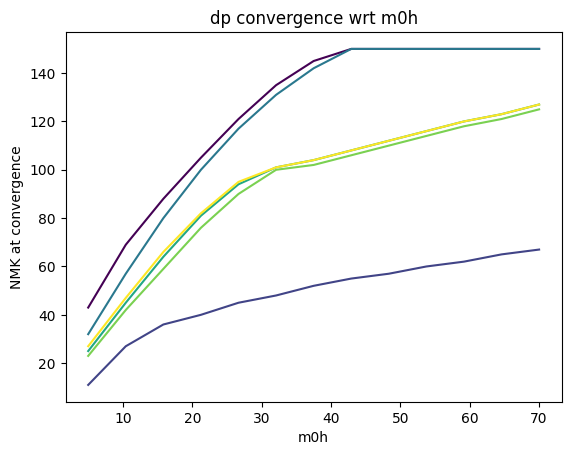

In [139]:
plot_wrt_one(all_data["left ratio"], "dp", 0.01, xlab = "(h-d1)/(h-d2)")
plot_wrt_one(all_data["right ratio"], "dp", 0.01, xlab = "h/(h-d2)")
plot_wrt_one(all_data["(h-d)/radwidth"], "dp", 0.01, xlab = "(h-d2)/radwidth")
plot_wrt_one(all_data["rad ratio"], "dp", 0.01, xlab = "radwidth/a2")
plot_wrt_one(all_data["m0h"], "dp", 0.01, xlab = "m0h")